In [1]:
import torch
import os
import sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.widgets import Button   

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
main_dir = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(main_dir)
path_dynamics_model_weights = os.path.join(main_dir, "old_files", "dynamics_model_weights_encoder")
import old_files.dynamics_learning_encoder.mlmodel_encoder as mlmodel
dynamics_model = mlmodel.load_model("run_4_encoder_increased_wind30.pth", path_dynamics_model_weights)
dynamics_model.mu.to(device)
dynamics_model.f.to(device)
dynamics_model.g.to(device)

g(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
  (relu): ReLU()
)

In [2]:
class SimDataFeasability:
    def __init__(self, data_path):
        with open(data_path, 'rb') as f:
            self.trajectory_data = pickle.load(f)
        self.dt = 0.01
        self.a_g = 9.81
        self.trajectory_data['a_x_NN'], self.trajectory_data['a_y_NN'] = self.NN_dynamics_inference_zero_wind(
            self.trajectory_data['velocities'][:, 0], self.trajectory_data['velocities'][:, 1],
            self.trajectory_data['controls'][:, 0], self.trajectory_data['controls'][:, 1]
        )

        self.trajectory_data['a_x_NN_err'] = self.trajectory_data['accelerations'][:, 0] - self.trajectory_data['a_x_NN']
        self.trajectory_data['a_y_NN_err'] = self.trajectory_data['accelerations'][:, 1] - self.trajectory_data['a_y_NN']

    def NN_dynamics_inference_zero_wind(self, v_x, v_y, roll, pitch):
        v_x = torch.tensor(v_x, dtype=torch.float32).to(device)           # []
        v_y = -torch.tensor(v_y, dtype=torch.float32).to(device)
        velocity = torch.stack((v_x, v_y), dim=1)  # [N, 2]
        roll = torch.tensor(-roll, dtype=torch.float32).to(device)
        pitch = torch.tensor(-pitch, dtype=torch.float32).to(device)
        control = torch.stack((pitch, roll), dim=1)  # [N, 2]
         # NN prediction with zero wind
        with torch.no_grad():
            wind_zero = torch.tensor([[0.0, 0.0]], dtype=torch.float32).to(device)  # [1, 2]
            wind_encoding_zero = dynamics_model.mu(wind_zero)  # [1, latent_dim]
            wind_encoding_zero = wind_encoding_zero.repeat(velocity.shape[0], 1)
            output_NN = dynamics_model.f(torch.cat([velocity, wind_encoding_zero], dim=1)) + \
                        torch.matmul(dynamics_model.g(velocity).reshape(-1, 2, 2), control.unsqueeze(-1)).squeeze(-1)  # [N, 2]
            a_x_NN = output_NN[:, 0].cpu().numpy()
            a_y_NN = -output_NN[:, 1].cpu().numpy()
        return a_x_NN, a_y_NN

In [3]:
adapt_data = SimDataFeasability('../../quadrotor_dynamics_varied_wind_rw_control_ic500_ws42.pkl')

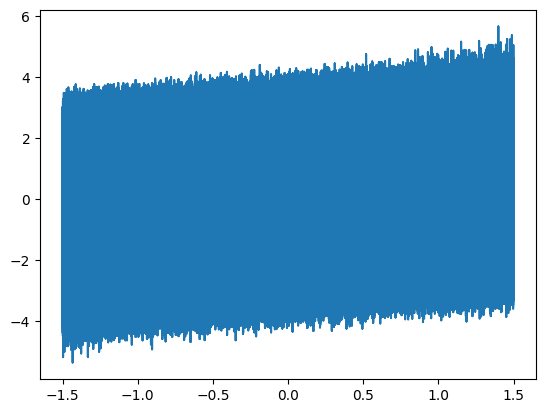

In [4]:
plt.plot(adapt_data.trajectory_data['winds'][:,0], adapt_data.trajectory_data['a_x_NN_err'], label='a_x_NN_err vs wind_x')

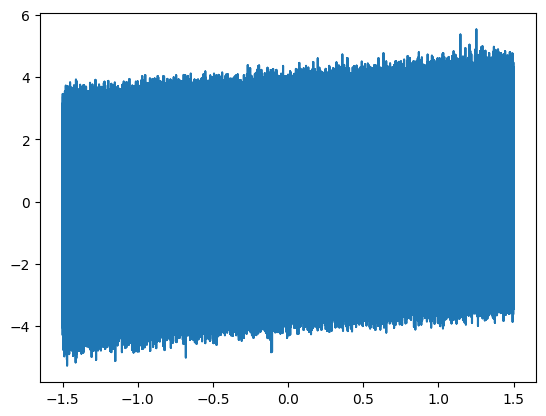

In [5]:
plt.plot(adapt_data.trajectory_data['winds'][:,1], adapt_data.trajectory_data['a_y_NN_err'], label='a_y_NN_err vs wind_y')